In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef
from utils import create_mask as cm
from utils import ed_plotting as eplt

from numpyro.infer.initialization import init_to_sample #new

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# INPUT CELL

summary = 'Fit Ilias Top 5 Templates with 1901.03822 bubbles template'
gpu_id = '2'

mod_id = 40000 # following notebooks_canon format
svi_id = 42
sim_seed = -1 ; str_sim_seed = str(sim_seed)

# Important Fit Settings 
rig_temp_list = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_list = ['pib', 'ics'] # pib, ics, blg
var_temp_list = [] # nfw, dsk

is_gp = True
gp_deriv = False

blg_id = 1 # Coleman2019 bulge
data_file = 'fermi_data_sum'
rig_temp_sim = ['iso', 'psc', 'bub']
hyb_temp_sim = ['pib', 'ics', 'blg']
var_temp_sim = ['nfw']
is_custom_blg = False
custom_blg_id = 0

Nu = 300
u_option = 'fixed' # 'float' or 'fixed'
u_grid_type = 'sunflower'
u_weights = 'data'

Np = 50
p_option = 'match_u' # 'float' or 'fixed'
Nsub = 500

# Rest of parameters set to default values
ebin = 10
is_float64 = False
debug_nans = False
no_ps_mask = False
p_grid_type = 'healpix_bins'
p_weights = None
gp_kernel = 'Matern32'
gp_params = ['float', 'float']
gp_scale_option = 'Linear' # 'Linear' or 'Cholesky'
monotonicity_hyperparameter = 0.01
nfw_gamma = 'vary'
blg_names = ef.gen_blg_name_(blg_id) # needed only for saving in this case
dif_names = ['czms-8t-']

# fit specs, strings loaded for file saving

ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 20000
str_n_steps = str(n_steps)

lr = 0.1
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 8
str_num_particles = str(num_particles)

svi_seed = 0
str_svi_seed = str(svi_seed)

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# directory where the data and fits are stored
sim_name = 'fit_to_data_v2'
data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# directory where fits stored
fit_filename, module_name = ef.generate_fit_filename(rig_temp_list, hyb_temp_list, var_temp_list, rig_temp_sim, hyb_temp_sim, var_temp_sim, is_gp, gp_deriv, is_custom_blg, custom_blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
os.system("mkdir -p "+fit_dir)

# command that converts numbers/strings to text strings
txt = lambda x: ('\'' + str(x) + '\'')

# save settings to module

with open(fit_dir + '__init__' +  '.py', 'w') as i:
    i.write('')

with open(fit_dir + module_name + '.py', 'w') as f:
    f.write('# Important Model Settings\n')
    f.write('rig_temp_list = ' + str(rig_temp_list) + '\n')
    f.write('hyb_temp_list = ' + str(hyb_temp_list) + '\n')
    f.write('var_temp_list = ' + str(var_temp_list) + '\n')
    f.write('is_gp = ' + str(is_gp) + '\n')
    f.write('gp_deriv = ' + str(gp_deriv) + '\n')
    f.write('data_file = ' + txt(data_file) + '\n')
    f.write('dif_names = ' + str(dif_names) + '\n')
    f.write('rig_temp_sim = ' + str(rig_temp_sim) + '\n')
    f.write('hyb_temp_sim = ' + str(hyb_temp_sim) + '\n')
    f.write('var_temp_sim = ' + str(var_temp_sim) + '\n')
    f.write('is_custom_blg = ' + str(is_custom_blg) + '\n')
    f.write('custom_blg_id = ' + str(custom_blg_id) + '\n')
    f.write('sim_seed = ' + str(sim_seed) + '; str_sim_seed = ' + txt(sim_seed) + '\n')
    f.write('Nu = ' + str(Nu) + '\n')
    f.write('u_option = ' + txt(u_option) + '\n')
    f.write('u_grid_type = ' + txt(u_grid_type) + '\n')
    f.write('u_weights = ' + txt(u_weights) + '\n')
    f.write('Np = ' + str(Np) + '\n')
    f.write('p_option = ' + txt(p_option) + '\n')
    f.write('Nsub = ' + str(Nsub) + '\n')
    f.write('\n')
    f.write('# Rest of model parameters set to default values\n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('is_float64 = ' + str(is_float64) + '\n')
    f.write('debug_nans = ' + str(debug_nans) + '\n')
    f.write('no_ps_mask = ' + str(no_ps_mask) + '\n')
    f.write('p_grid_type = ' + txt(p_grid_type) + '\n')
    f.write('p_weights = ' + str(p_weights) + '\n')
    f.write('gp_kernel = ' + txt(gp_kernel) + '\n')
    f.write('gp_params = ' + str(gp_params) + '\n')
    f.write('gp_scale_option = ' + txt(gp_scale_option) + '\n')
    f.write('monotonicity_hyperparameter = ' + str(monotonicity_hyperparameter) + '\n\n')
    if nfw_gamma == 'vary':
        f.write('nfw_gamma = ' + txt(nfw_gamma) + '\n')
    else:
        f.write('nfw_gamma = ' + str(nfw_gamma) + '\n')
    f.write('blg_names = ' + str(blg_names) + '\n\n')

# add these additional parameters and the str_ versions to text file
with open(fit_dir + module_name + '.py', 'a') as f:
    f.write('\n')
    f.write('# SVI Parameters \n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('str_ebin = str(ebin)' + '\n')
    f.write('guide = ' + txt(guide) + '\n')
    f.write('str_guide = guide' + '\n')
    f.write('n_steps = ' + str(n_steps) + '\n')
    f.write('str_n_steps = str(n_steps)' + '\n')
    f.write('lr = ' + str(lr) + '\n')
    f.write('str_lr = ' + txt(lr) + '\n')
    f.write('num_particles = ' + str(num_particles) + '\n')
    f.write('str_num_particles = str(num_particles)' + '\n')
    f.write('svi_seed = ' + str_svi_seed + '\n')
    f.write('str_svi_seed = ' + txt(str_svi_seed))

# add summary to its own text file
with open(fit_dir + 'summary' + '.txt', 'w') as f:
    f.write(summary)

In [4]:
from models.poissonian_gp import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )

In [5]:
# define custom optimizer (can be None if want to use default)
import optax
import numpyro
from numpyro import optim

schedule = optax.warmup_exponential_decay_schedule(
    init_value=0.005,
    peak_value=0.05,
    warmup_steps=1000,
    transition_steps=3000,
    decay_rate=1./jnp.exp(1.),
    transition_begin=2000,
)
optimizer = optim.optax_to_numpyro(
    optax.chain(
        optax.clip(1.),
        optax.adam(learning_rate=schedule), 
    )
)

In [6]:
# configure model, run SVI, and generate samp 
rng_key = jax.random.PRNGKey(sim_seed) #new
rng_key, key = jax.random.split(rng_key)
ebinmodel.config_model(ebin=ebin)
svi_results = ebinmodel.cfit_SVI(
    rng_key=key,
    guide=guide, 
    n_steps=n_steps, 
    lr=lr, 
    num_particles=num_particles,
    ebin=ebin, optimizer = optimizer,
    record_states = False, record_min = False, progress_bar = True,
    init_loc_fn = init_to_sample #new
)

100%|██████████| 20000/20000 [04:18<00:00, 77.40it/s, init loss: 445124.8125, min loss inf, avg loss [19901-20000]: 35695.6602]


Text(0.5, 1.0, 'Loss over last 1000 steps')

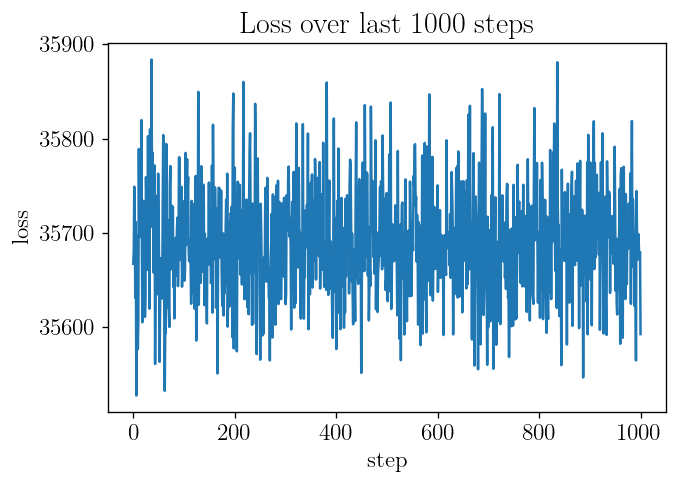

In [7]:
# check last 1000 steps of loss
plt.plot(svi_results.losses[-1000:])
plt.xlabel('step')
plt.ylabel('loss')  
plt.title('Loss over last 1000 steps')

In [8]:
# this cell is different from v0.3, we now specify the templates that we want to sample from a list of names
# instead of just getting all the samples. 

rng_key, key = jax.random.split(rng_key) 
ebinmodel.predictive(ebinmodel.guide, num_samples = 1, params = svi_results.params)
ie = ebinmodel.ebin

keys = list(ebinmodel.pred(key, ie).keys()) # get keys
keys.remove('_auto_latent') # remove _auto_latent
if is_gp: 
    keys.append('log_rate') 

samples_dict = ebinmodel.cget_all_samples_vec(keys, key, 10000, svi_results, custom_mask = None) #v4 (vectorized)
samples_dict['log_rate_nmask'] = ebinmodel.cget_samples_vec('log_rate', key, 10000, svi_results, custom_mask = ebinmodel.normalization_mask) # samples in normalization mask
samples_dict['S_gp'] = jnp.exp(samples_dict['log_rate_nmask']).mean(axis = -1) # S_gp using normalization mask

#  generate GP across entire inner ROI with no PS / Disk masks
mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 20.,
        inner = 0.,
    )
samples_dict['log_rate_cmask'] = ebinmodel.cget_samples_vec('log_rate', key, 10000, svi_results, custom_mask = mask) # samples in custom mask

In [9]:
# augment samples_dict to include entire maps of samples
temp_sample_dict = ef.generate_temp_sample_maps(samples_dict, ebinmodel, gp_samples = samples_dict['log_rate'], custom_num = 1000) # templates over inner ROI
temp_sample_dict_cmask = ef.generate_temp_sample_maps(samples_dict, ebinmodel, gp_samples = samples_dict['log_rate_cmask'], custom_num = 1000, custom_mask = mask) # template over custom mask

names = list(temp_sample_dict.keys())
for name in names:
    samples_dict[name] = temp_sample_dict[name]
    samples_dict[name + '_cmask'] = temp_sample_dict_cmask[name]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 682.45it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 819.01it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 735.95it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 805.06it/s]


In [10]:
# calculate LL samples for violin plots and model comparison

# load raw data in inner roi
ebin = ebinmodel.ebin
mask_p = ebinmodel.mask_roi_arr[ebin]
data = ebinmodel.counts[ebin][~mask_p]

# generate LL samples of inner roi
ll_inner = ef.generate_ll_samples(temp_sample_dict, data)

# load raw data in outer roi LL
outer_mask = ebinmodel.outer_mask[10]
data = ebinmodel.counts[ebin][~outer_mask]

# generate LL samples of outer roi
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
temp_sample_dict_outer = ef.generate_temp_sample_maps(samples_dict, ebinmodel, custom_num = 1000, custom_mask = outer_mask, gp_samples = None)
ll_outer = ef.generate_ll_samples(temp_sample_dict_outer, data)

# calculate LL in total ROI
ll_total = ll_inner + ll_outer

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 752.29it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 787.24it/s]


In [11]:
# save ll_samples
samples_dict['ll_inner'] = ll_inner
samples_dict['ll_outer'] = ll_outer
samples_dict['ll_total'] = ll_total

In [12]:
# save svi results and samples to file
file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

pickle.dump(
    (samples_dict, svi_results), 
    open(fit_dir + file_name, 'wb'))

In [13]:
# load true data if exits
if data_file != 'fermi_data_sum':
    temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()
else:
    pass

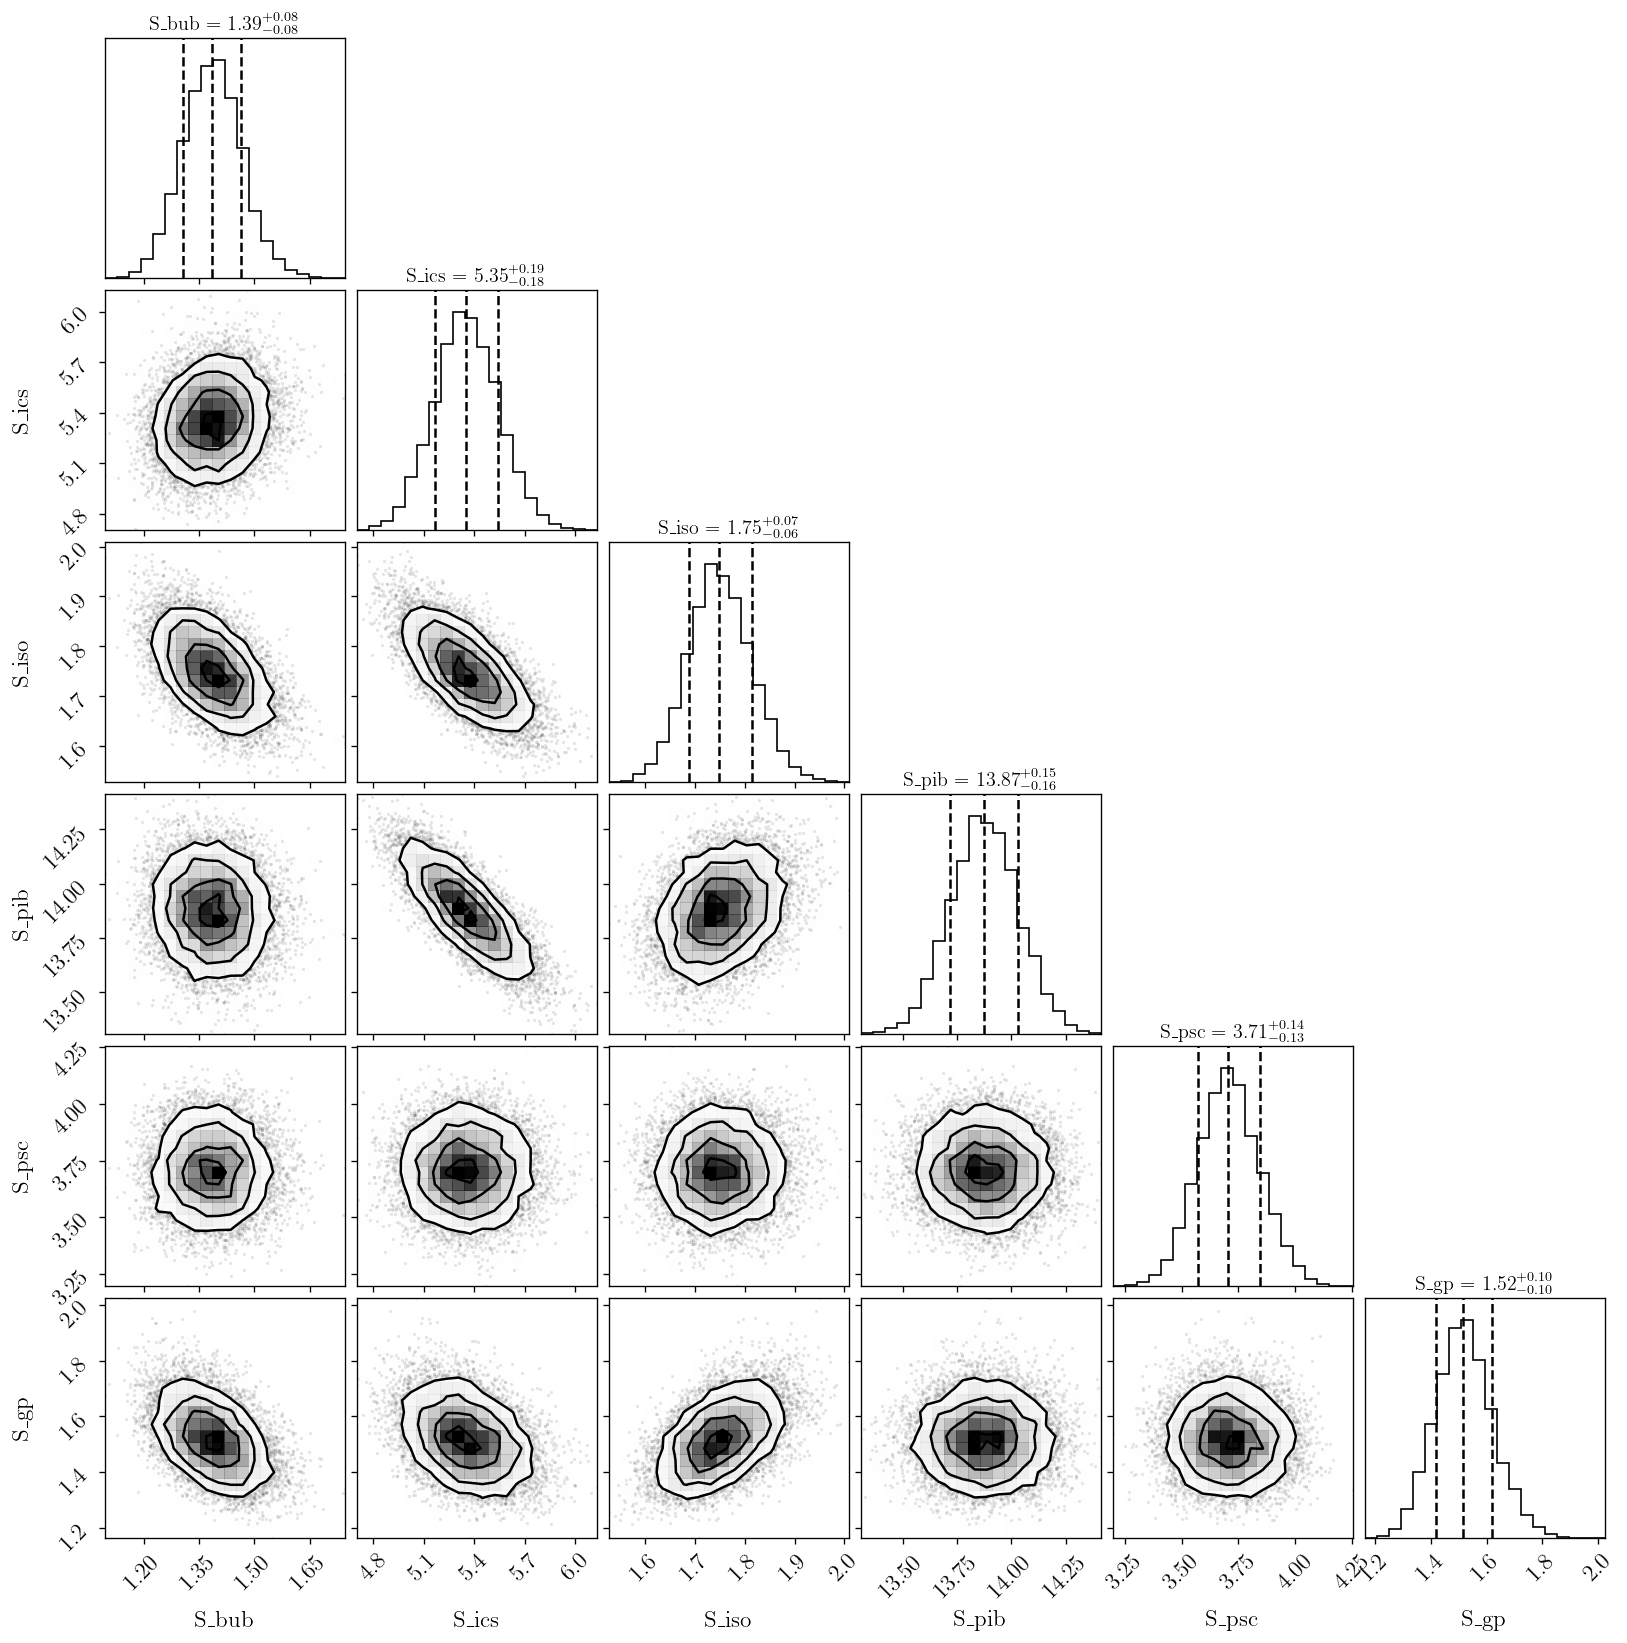

In [14]:
# generate corner plots
corner_keys = [k for k in list(samples_dict.keys()) if 'S_' in k]
corner_samples = {k : samples_dict[k] for k in corner_keys}

if data_file != 'fermi_data_sum':
    fig = ef.make_corner_plots(corner_samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)
else:
    fig = ef.make_corner_plots(corner_samples, with_mean_vlines = False, sim_vlines = False, temp_dict = None)

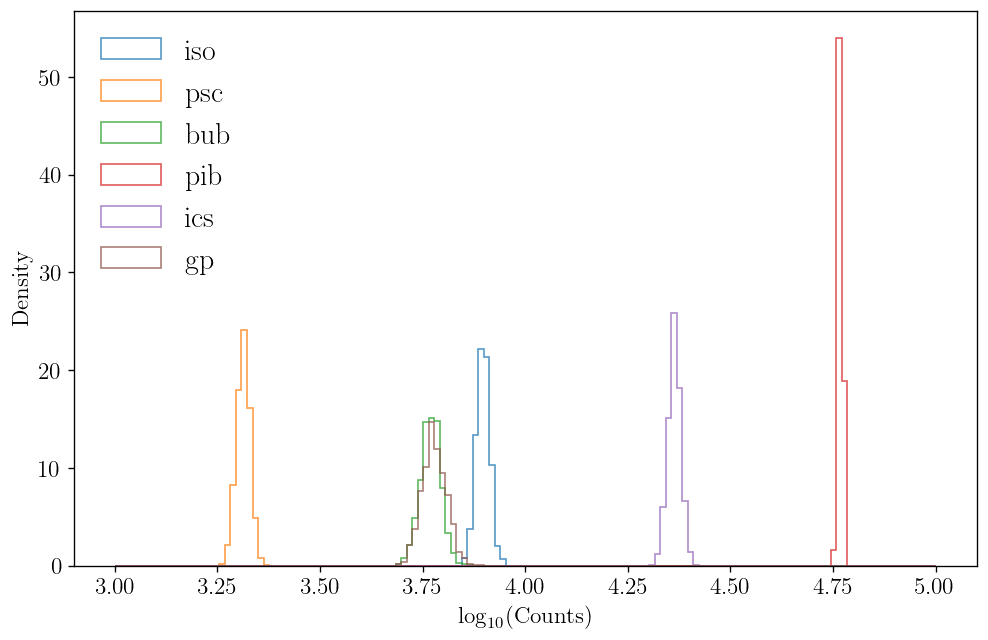

In [15]:
# generate samples and plot histograms of log counts
mask_p = ebinmodel.mask_roi_arr[ebin]
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
if data_file != 'fermi_data_sum':
    fig = ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False)
else:
    ef.tot_log_counts_hist(temp_sample_dict, None, None, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False)

/data/edr76/gce-gp/notebooks/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: set_ticklabels() should only be used with a fixed

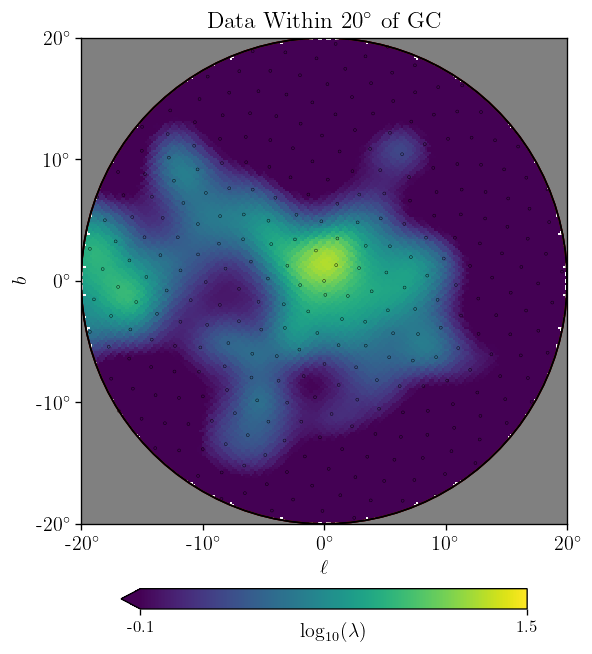

In [16]:
# Bottom: Data Processing 
fig, ax = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1) # DEFINING AXES FROM HERE DOES NOT WORK SEE SUBPLOT ARGUMENT BELOW

q = np.percentile(temp_sample_dict_cmask['gp'], 50, axis = 0)
m = ef.convert_masked_array_to_hp_array(q, mask, log_option = True, nside = 128)
plt.axes(ax)
eplt.inner_roi_map(m, title = 'Data Within 20$^{\circ}$ of GC', vmin = -0.1, vmax = 1.5, subplot = 111)

xu_f = ebinmodel.xu_f
xu_f_r = np.deg2rad(xu_f)
plt.scatter(xu_f_r[:,0], xu_f_r[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

In [17]:
# 1d slices
# load cartesian grid
n_pixels = 160 # set to 40 if too slow
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords(n_pixels = n_pixels)
slice_val = 3.  

# cartesian map of masks to keep track of masking for plots
mask_map = np.zeros((~ebinmodel.mask_roi_arr[ebin]).sum())
mask_map_cart = ef.healpix_to_cart(mask_map, ebinmodel.mask_roi_arr[ebin], n_pixels = n_pixels, nside = 128, nan_fill = True) # doesn't matter what mask used

In [18]:
# cartesian gp samples
exp_gp_samples = temp_sample_dict_cmask['gp']
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels = n_pixels, nside = 128)

if data_file != 'fermi_data_sum':
    # create gp_true from scratch
    temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
    ebinmodel.load_templates(temp_names_sim, blg_names, dif_names)
    gp_true = ( temp_dict['S_blg'] * ebinmodel.blg_temps[0].at_bin(ebin, mask) + temp_dict['S_nfw'] * ebinmodel.nfw_temp.get_NFW2_template(gamma = temp_dict['gamma'])[~mask] )

100%|██████████| 1000/1000 [00:28<00:00, 34.98it/s]


Slice at y = 3.12500 deg


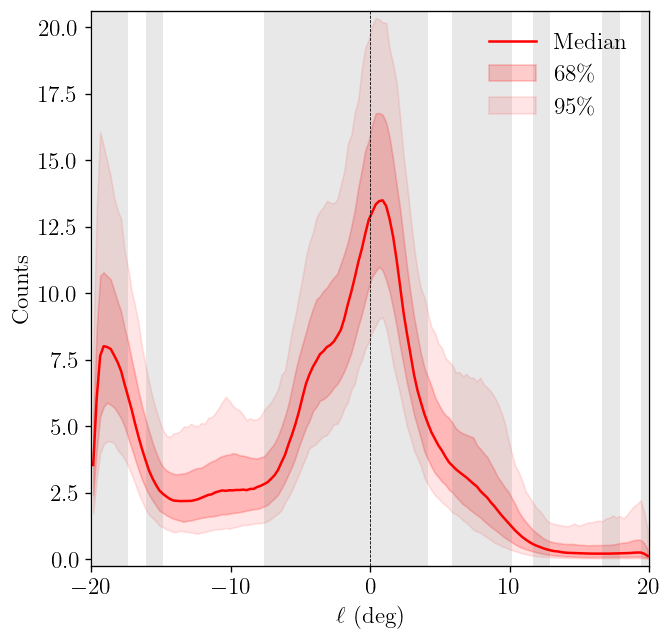

In [19]:
# load cart_1d_plot inputs
q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0) # cartesian sample map quantiles
sim_cart = None # simulated rate cartesian map
raw_cart = None

# plot 1d slice
fig, ax = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1)
plt.axes(ax)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,)

In [20]:
# 1D slice of total rate
tot_samples = jnp.zeros(np.sum(~mask))
tot_names = list(temp_sample_dict_cmask.keys())
for tot_name in tot_names:
    tot_samples += temp_sample_dict_cmask[tot_name]
tot_samples_cart = ef.multi_healpix_to_cart(tot_samples, mask, n_pixels = n_pixels, nside = 128)

if data_file != 'fermi_data_sum':
    sim_samples = jnp.zeros(np.sum(~mask))
    for sim_name in temp_names_sim:
        sim_samples += temp_dict[sim_name][~mask]

100%|██████████| 1000/1000 [00:28<00:00, 34.97it/s]


Slice at y = 3.12500 deg


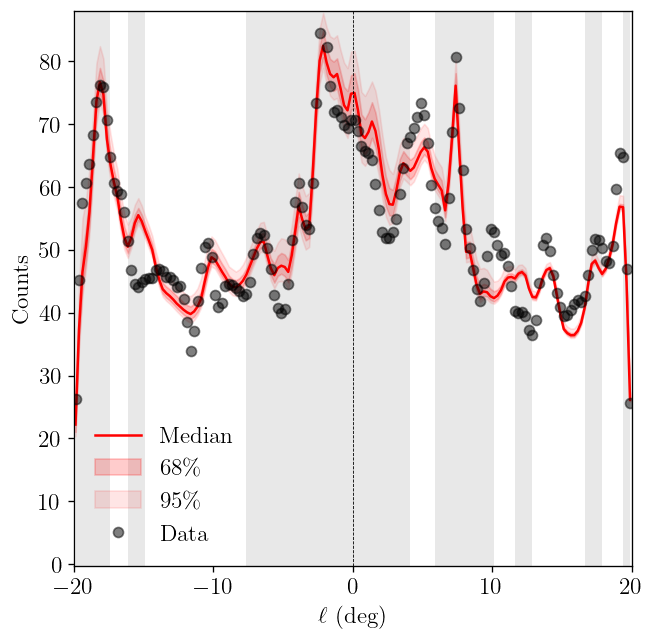

In [21]:
# load cart_1d_plot inputs
q = np.percentile(tot_samples_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = None
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels = n_pixels, nside = 128)

# plot 1d slice
fig, ax = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1)
plt.axes(ax)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,)

In [22]:
rng_key, key = jax.random.split(rng_key)
poisson_samples = jax.random.poisson(key, tot_samples)
data_residuals = ebinmodel.counts[ebin][~mask] - poisson_samples
data_residuals_cart = ef.multi_healpix_to_cart(data_residuals, mask, n_pixels = n_pixels, nside = 128)

100%|██████████| 1000/1000 [00:28<00:00, 34.90it/s]


Slice at y = -7.87500 deg


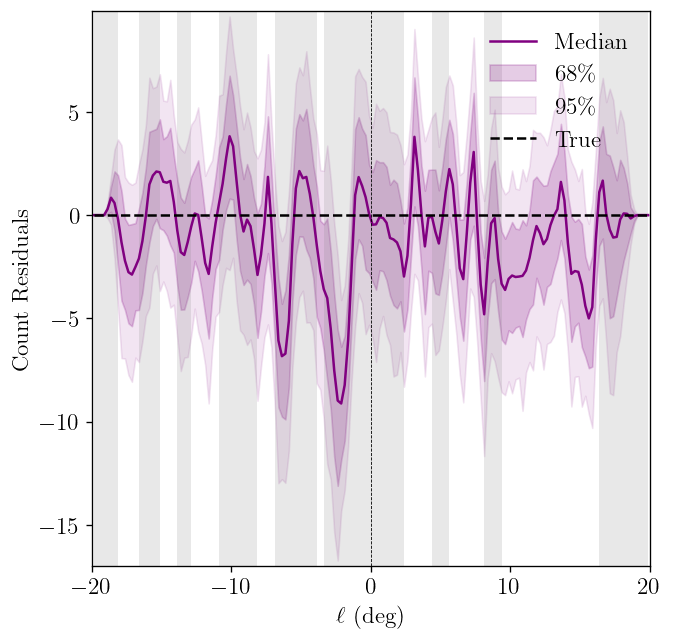

In [23]:
q = np.percentile(data_residuals_cart, [2.5,16,50,84,97.5], axis = 0)
sim_cart = np.zeros((n_pixels,n_pixels))
raw_cart = None
slice_val = -8.

# plot 1d slice
fig, ax = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1)
plt.axes(ax)
eplt.cart_plot_1d(q, sim_cart = sim_cart, raw_cart = raw_cart, 
    slice_val = slice_val, 
    mask_map_cart = mask_map_cart,
    n_pixels = n_pixels,
    ylabel = 'Count Residuals', q_color = 'purple', line_color = 'k', ls = '--')

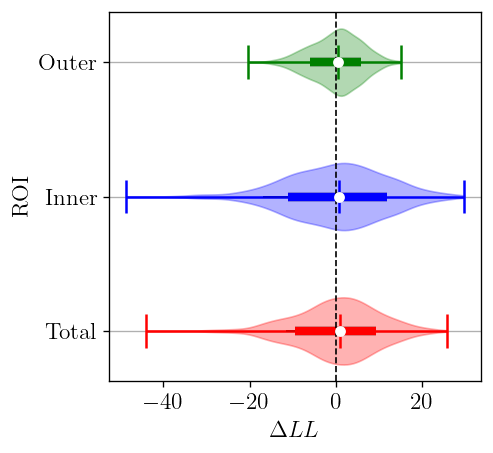

In [24]:
# make violin plots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

# load data
all_data = [ll_total - ll_total.mean(), ll_inner - ll_inner.mean(), ll_outer - ll_outer.mean()]
colors = ['red', 'blue', 'green']

# plot violin plot
eplt.violin_plot(all_data, colors, ax)